In [105]:
import pandas as pd

import numpy as np
import wfdb
import os
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.io as pio
#pio.renderers.default = "colab"
import neurokit2 as nk
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


#pio.renderers.default = "browser"  # Abre o gráfico no navegador
# ou
#pio.renderers.default = "notebook"  # Usa o modo compatível com notebooks
# Configurar o tamanho da figura globalmente
plt.rcParams["figure.figsize"] = (16, 6)  # Ajuste a largura e altura aqui

# Definir o número máximo de linhas a serem exibidas
pd.set_option('display.max_rows', None)  # Exibe todas as linhas

In [ ]:
# import pandas as pd
# import glob

# # Define o padrão para os arquivos CSV

# path = r'D:\Projeto_Tese_mestrado\02_Dataset\dados_ECG\High-resolution_ECG\P0*'
# #path_holter = r'D:\Projeto_Tese_mestrado\02_Dataset\dados_ECG\Holter_ECG\P0*'

# #path = r'E:/Repositorio_Git/zzz-projeto_final/dados/ca-*.csv'


# # Usando glob para pegar todos os arquivos que seguem o padrão
# arquivos = glob.glob(path)
# #arquivos_path_holter = glob.glob(path_holter)
# arquivos = [os.path.splitext(arquivo)[0] for arquivo in arquivos] # tirando as a extensões

# #arquivos_path_holter = [os.path.splitext(arquivos_path_holter)[0] for arquivos_path_holter in arquivos_path_holter] # tirando as a extensões
# #arquivos_path_holter

# record = wfdb.rdrecord(arquivos_path_holter[0])


# # Exibir as informações do arquivo
# print(record.__dict__)
#arquivos_path_holter

#lista_sem_duplicatas = pd.Series(arquivos).unique().tolist() # removando duplicadas

In [8]:
import duckdb


# Conectar ao banco de dados DuckDB
# read_only somente leitura para evitar conflito
conn = duckdb.connect(r"D:\Projeto_Tese_mestrado\02_Dataset\Duckedb\High-resolution_ECG\5minutos\banco_ecg.duckdb", read_only=True)

# Carregar apenas a lista de pacientes
pacientes = conn.execute("SELECT DISTINCT id_paciente FROM ecg_pacientes ORDER BY id_paciente").fetchdf()

In [ ]:
len(pacientes)

687

# Clustering de Séries Temporais (não supervisionado)

Se o seu conjunto de dados de ECG não tem rótulos e você deseja agrupar os sinais com base em padrões semelhantes, você pode usar clustering, como o K-means ou o DBSCAN. Esses algoritmos podem ser aplicados diretamente em séries temporais, e você poderia extrair características importantes, como frequências, amplitude e padrões temporais para classificar as séries temporais.

Exemplo:
Transformação das Séries Temporais: Você pode usar métodos como a Transformada Rápida de Fourier (FFT) para extrair características do domínio da frequência, ou Análise de Componentes Principais (PCA) para reduzir a dimensionalidade.
Aplicação de K-means ou outro algoritmo de clustering: Após a extração das características, você pode usar K-means para agrupar os sinais de ECG em diferentes clusters, representando padrões semelhantes.

## Testando com X

In [106]:
ecg_x = conn.execute("""SELECT sinal_x FROM ecg_pacientes
                         WHERE id_paciente = 'P0001_H' """).fetchdf()


In [107]:
ecg_x = np.array(ecg_x)

In [108]:
# Fazendo uma limpeza nos dados 
ecg_x = nk.ecg_clean(ecg_x, sampling_rate=1000, method='neurokit')

In [109]:
ecg_x

array([0.00175539, 0.00211208, 0.00246878, ..., 0.0038062 , 0.00388259,
       0.00399651], shape=(300000,))

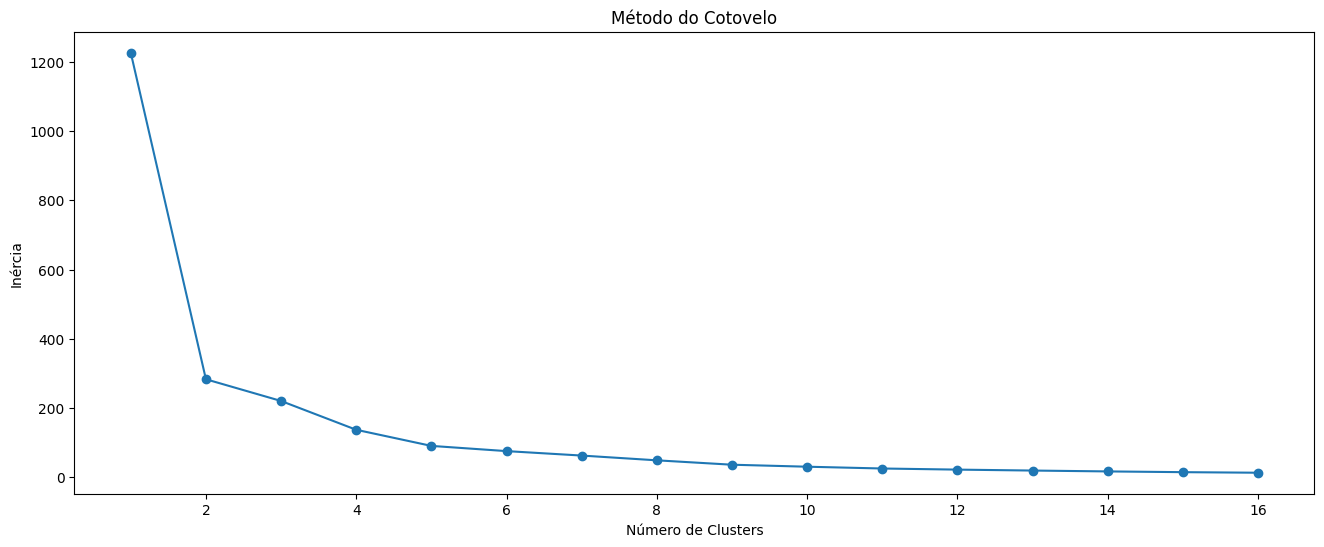

In [70]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Suponha que X seja sua matriz de características extraídas de séries temporais ECG
# Pode ser a Transformada Rápida de Fourier ou outras características extraídas

#ecg_clean = ecg_x['sinal_x']

#feactures  = resultado_x.drop(['ECG_Raw','ECG_Clean','ECG_Rate','ECG_Quality','ECG_Phase_Atrial'], axis =1)

# Reduzindo a dimensionalidade para visualização (usando PCA)
#pca = PCA(n_components=4)
#X_reduced = pca.fit_transform(feactures)  # X é um conjunto de dados com as características extraídas

ecg_clean_2d = ecg_x.reshape(-1, 1)  # ou ecg_clean.to_numpy().reshape(-1, 1)

# Definir a faixa de números de clusters que você deseja testar

# Porque usar 17 porque ao todo são 15 colunas separadas de ondas que o neurokit distribui são
# colunas = [
#     'ECG_R_Peaks', 'ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 
#     'ECG_Q_Peaks', 'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 
#     'ECG_T_Peaks', 'ECG_T_Onsets', 'ECG_T_Offsets', 'ECG_Phase_Atrial',
#     'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular',
#     'ECG_Phase_Completion_Ventricular'
# ] dessas colunas colunas quero testar se o modelo tambem consegui classificar depois eu vou testar com as 6 ondas, eu coloquei 17 para ver se depois do dos 15 o modelo consegue encontrar diferença.
n_clusters_range = range(1, 17)  # Testando de 1 a 17 clusters 
inertia = []

# Calcular a inércia para cada número de clusters
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(ecg_clean_2d)  
    inertia.append(kmeans.inertia_)

# Plotando a curva de inércia
plt.plot(n_clusters_range, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

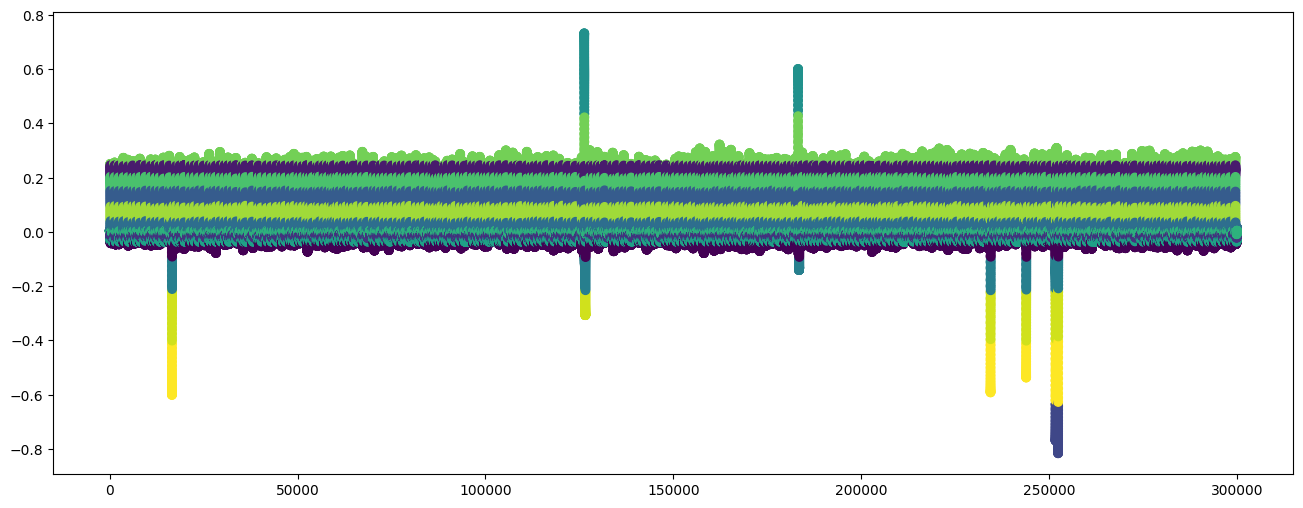

In [71]:
# Agora aplicando o KMeans
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(ecg_clean_2d)


plt.scatter(range(len(ecg_clean_2d)), ecg_clean_2d, c=clusters, cmap='viridis')
plt.show()

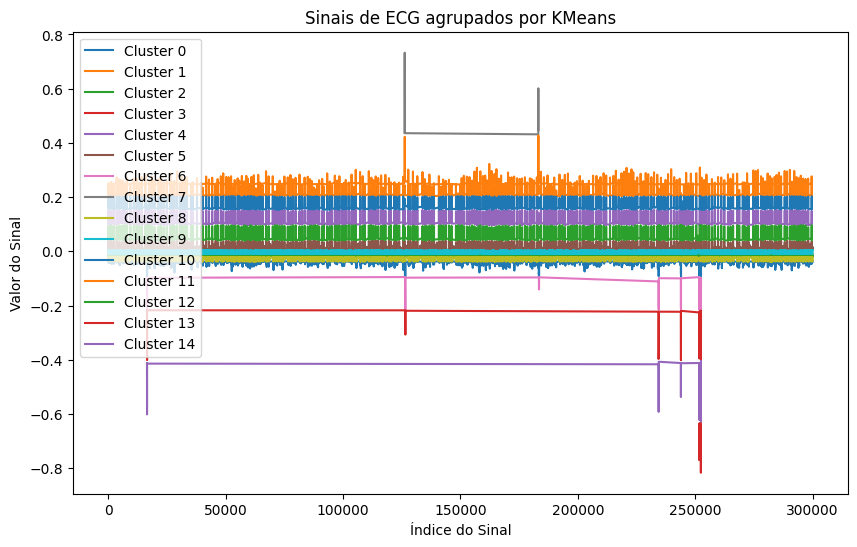

In [72]:
# Plotando os sinais agrupados de acordo com os clusters
plt.figure(figsize=(10, 6))
for cluster in np.unique(clusters):
    # Seleciona os índices dos dados que pertencem a cada cluster
    cluster_indices = np.where(clusters == cluster)[0]
    plt.plot(cluster_indices, ecg_clean_2d[cluster_indices], label=f"Cluster {cluster}")

plt.title("Sinais de ECG agrupados por KMeans")
plt.xlabel("Índice do Sinal")
plt.ylabel("Valor do Sinal")
plt.legend()
plt.show()


In [74]:
import pandas as pd

# Obter os rótulos dos clusters atribuídos
cluster_labels = clusters  # ou kmeans.labels_ se você usar kmeans.fit_predict()

# Agora, se você tiver os dados originais em um DataFrame (por exemplo, 'ecg_clean_2d'),
# podemos adicionar a coluna de rótulos dos clusters ao DataFrame original

df = pd.DataFrame(ecg_clean_2d, columns=['ECG_Feature'])
df['Cluster'] = cluster_labels

# Agora, você pode visualizar os dados por cluster
# Por exemplo, para ver todos os dados que pertencem ao cluster 0:
cluster_0_data = df[df['Cluster'] == 0]
#print("Cluster 0 data:\n", cluster_0_data)

# Para ver todos os dados de outros clusters, você pode fazer o mesmo
# Cluster 1
cluster_1_data = df[df['Cluster'] == 1]
#print("Cluster 1 data:\n", cluster_1_data)

# E assim por diante, ou então você pode agrupar os dados por cluster e visualizar de forma resumida:
df.groupby('Cluster').describe()


ECG_Feature                                                    \
              count      mean       std       min       25%       50%   
Cluster                                                                 
0           28079.0 -0.045198  0.007351 -0.094602 -0.048759 -0.043209   
1            6394.0  0.226225  0.012172  0.204048  0.215842  0.226471   
2           84411.0 -0.015336  0.003612 -0.021883 -0.018352 -0.015309   
3              82.0 -0.738856  0.052477 -0.816197 -0.775670 -0.747502   
4            3745.0  0.126076  0.016413  0.097063  0.111912  0.126141   
5           26383.0  0.012752  0.007179  0.004955  0.007462  0.010655   
6             383.0 -0.144219  0.033493 -0.216015 -0.168594 -0.136872   
7             109.0  0.592169  0.084864  0.431657  0.530661  0.588846   
8           61107.0 -0.028541  0.004297 -0.036817 -0.032140 -0.028139   
9           75113.0 -0.002976  0.003879 -0.009102 -0.006322 -0.003328   
10           4735.0  0.181240  0.014375  0.153971  0.169076  0.182492   
11           5132.0  0.266541  0.015948  0.246564  0.254586  0.263954   
12           3906.0  0.067566  0.016576  0.040311  0.053048  0.067017   
13            258.0 -0.288643  0.047712 -0.401098 -0.309703 -0.284084   
14            163.0 -0.516283  0.060394 -0.627188 -0.569043 -0.520286   

                             
              75%       max  
Cluster                      
0       -0.039707 -0.036819  
1        0.236837  0.246556  
2       -0.012223 -0.009102  
3       -0.699484 -0.631813  
4        0.140470  0.153945  
5        0.015797  0.040291  
6       -0.118106 -0.094713  
7        0.658702  0.732603  
8       -0.024751 -0.021884  
9        0.000113  0.004955  
10       0.193816  0.204008  
11       0.274662  0.427145  
12       0.081929  0.097033  
13      -0.250025 -0.217199  
14      -0.465582 -0.404446

In [75]:
df.head()

,ECG_Feature,Cluster
0,0.001755,9
1,0.002112,9
2,0.002469,9
3,0.002813,9
4,0.003151,9


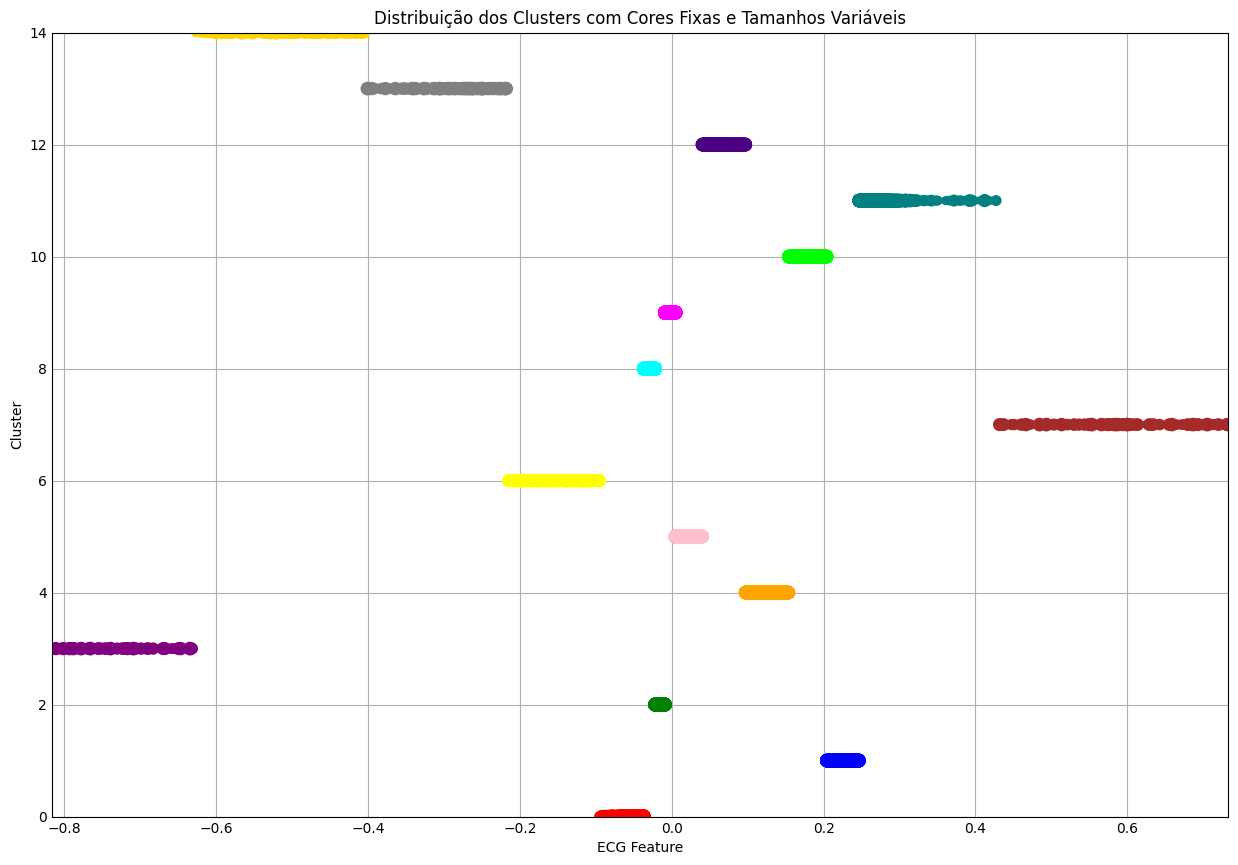

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que seu dataframe seja 'df' com as colunas 'ECG_Feature' e 'Cluster'

# Defina os dados
x = df['ECG_Feature']
y = df['Cluster']

# Definindo tamanhos aleatórios para os pontos
sizes = np.random.uniform(15, 80, len(x))

# Criando um mapeamento de cores dinamicamente, baseado no número de clusters
# Definindo um conjunto de cores fixas
colors_list = ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'yellow', 
               'brown', 'cyan', 'magenta', 'lime', 'teal', 'indigo', 'gray', 'gold', 'violet']

# Garantindo que o número de cores cubra o número de clusters
if len(colors_list) < len(np.unique(y)):
    extra_colors = plt.cm.get_cmap('tab20', len(np.unique(y)) - len(colors_list))
    colors_list.extend(extra_colors.colors)

# Mapeamento de cores para cada cluster
cluster_colors = {i: colors_list[i] for i in range(len(np.unique(y)))}

# Atribuindo cores fixas para cada cluster
colors = [cluster_colors[cluster] for cluster in y]


# Criação do gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Plotando os pontos com os tamanhos e cores fixas
scatter = ax.scatter(x, y, s=sizes, c=colors)

# Ajustando os limites dos eixos (caso necessário)
ax.set(xlim=(x.min(), x.max()), ylim=(y.min(), y.max()))

# Exibindo o gráfico
plt.title("Distribuição dos Clusters com Cores Fixas e Tamanhos Variáveis")
plt.xlabel("ECG Feature")
plt.ylabel("Cluster")
plt.show()


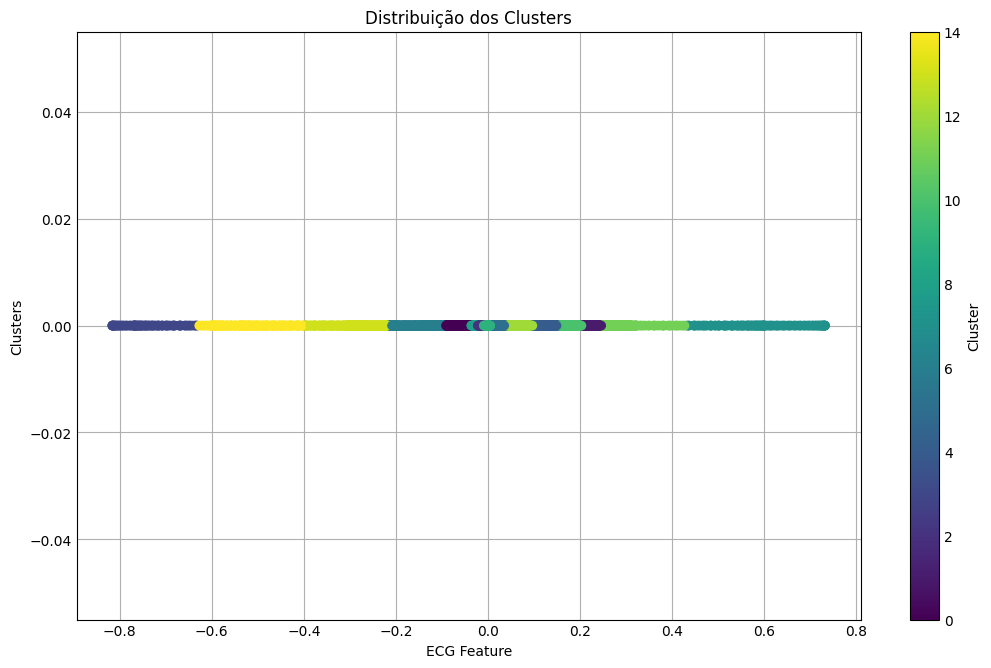

In [89]:
import matplotlib.pyplot as plt

# Plotando a dispersão dos clusters
plt.figure(figsize=(10, 6))
plt.scatter(df['ECG_Feature'], [0]*len(df), c=df['Cluster'], cmap='viridis', marker='o')
plt.title('Distribuição dos Clusters')
plt.xlabel('ECG Feature')
plt.ylabel('Clusters')
plt.colorbar(label='Cluster')
plt.show()


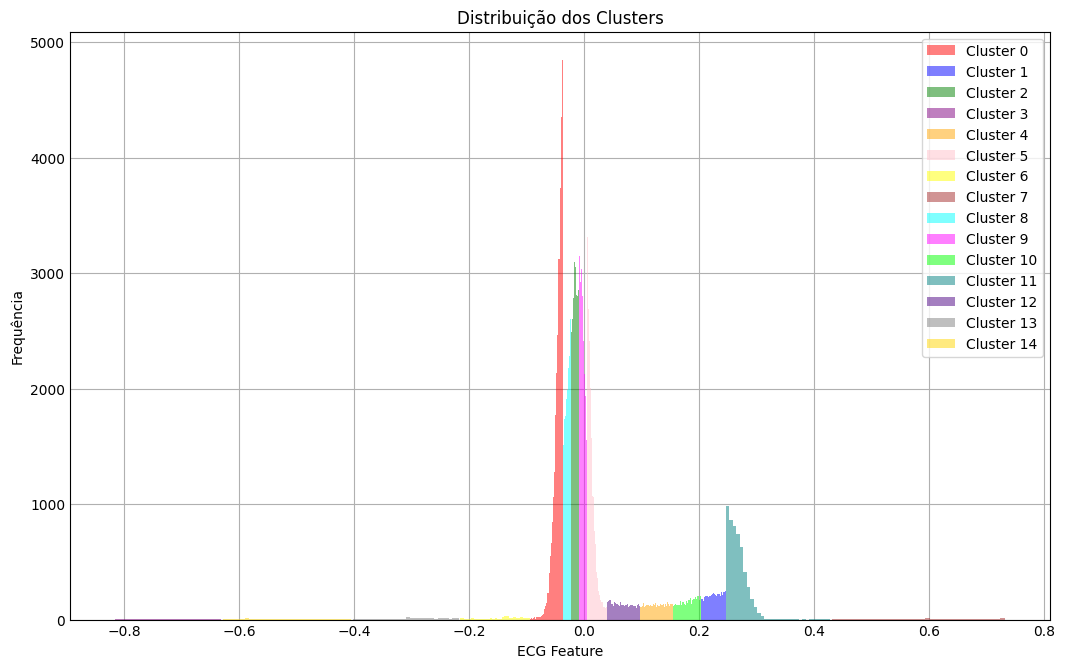

In [91]:
import matplotlib.pyplot as plt

# Definindo cores para cada cluster
cluster_colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'yellow', 
                  'brown', 'cyan', 'magenta', 'lime', 'teal', 'indigo', 'gray', 'gold', 'violet']

# Plotando histogramas para cada cluster com cores diferentes
plt.figure(figsize=(10, 6))

# Iterando sobre cada cluster e plotando seu histograma com a cor correspondente
for i, cluster in enumerate(sorted(df['Cluster'].unique())):
    plt.hist(df[df['Cluster'] == cluster]['ECG_Feature'], bins=30, alpha=0.5, 
             label=f'Cluster {cluster}', color=cluster_colors[i % len(cluster_colors)])

# Adicionando título e rótulos
plt.title('Distribuição dos Clusters')
plt.xlabel('ECG Feature')
plt.ylabel('Frequência')

# Exibindo a legenda
plt.legend()

# Exibindo o gráfico
plt.show()


# criando cluster simuladas a partir de das clusters certas 
- aqui vou pegar o resultado das clusters e criar um novo dataframe que cada coluna vai consrreponder a clusters e depois vou usar o pca para ver se consigo visualizar melhor o grafico e tirar alguma conclusão, deixando claro que não estou calibrando o modelo para ser melhor, mais se eu tirar boas conclusão vou testar outrso modelos como difusão ou autoencoder para calibrar essas separações de ondas 

In [92]:
import pandas as pd
import numpy as np


# Vamos agora criar um novo DataFrame onde cada coluna é um cluster
# Criamos uma lista com um dicionário de listas preenchidas com zeros
n_clusters = df['Cluster'].nunique()  # Número de clusters únicos

# Vamos criar um dicionário onde as chaves são os clusters e os valores são listas preenchidas com zeros
cluster_dict = {cluster: [] for cluster in range(1, n_clusters+1)}

# Preenche as listas com as características correspondentes de cada cluster
for cluster in range(1, n_clusters+1):
    # Seleciona todas as linhas do cluster
    cluster_data = df[df['Cluster'] == cluster]['ECG_Feature'].values
    cluster_dict[cluster] = cluster_data.tolist()

# Encontrar o tamanho máximo de listas para garantir a forma das colunas
max_len = max(len(v) for v in cluster_dict.values())

# Preencher com 0 as listas que são menores que o tamanho máximo
for cluster in cluster_dict:
    while len(cluster_dict[cluster]) < max_len:
        cluster_dict[cluster].append(0)

# Agora criamos um novo DataFrame com essas listas
cluster_df = pd.DataFrame(cluster_dict)

# Exibindo o novo DataFrame
#print(cluster_df)


In [197]:
cluster_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.211651,-0.009393,-0.637048,0.098497,0.005022,-0.108443,0.436924,-0.023413,0.001755,0.164249,0.248003,0.045402,-0.218472,-0.412227,0
1,0.219289,-0.009680,-0.653228,0.109604,0.005322,-0.125770,0.456305,-0.025813,0.002112,0.174637,0.249797,0.055534,-0.238223,-0.429678,0
2,0.226201,-0.009892,-0.668578,0.120736,0.005548,-0.143459,0.475581,-0.028031,0.002469,0.184650,0.250853,0.065978,-0.258169,-0.446574,0
3,0.232352,-0.010016,-0.683022,0.131761,0.005680,-0.161517,0.494644,-0.030037,0.002813,0.194232,0.251191,0.076665,-0.278214,-0.462920,0
4,0.237621,-0.010066,-0.696472,0.142717,0.005742,-0.180050,0.513389,-0.031730,0.003151,0.203282,0.250879,0.087516,-0.298203,-0.478721,0


In [198]:
cluster_df.shape

(84411, 15)

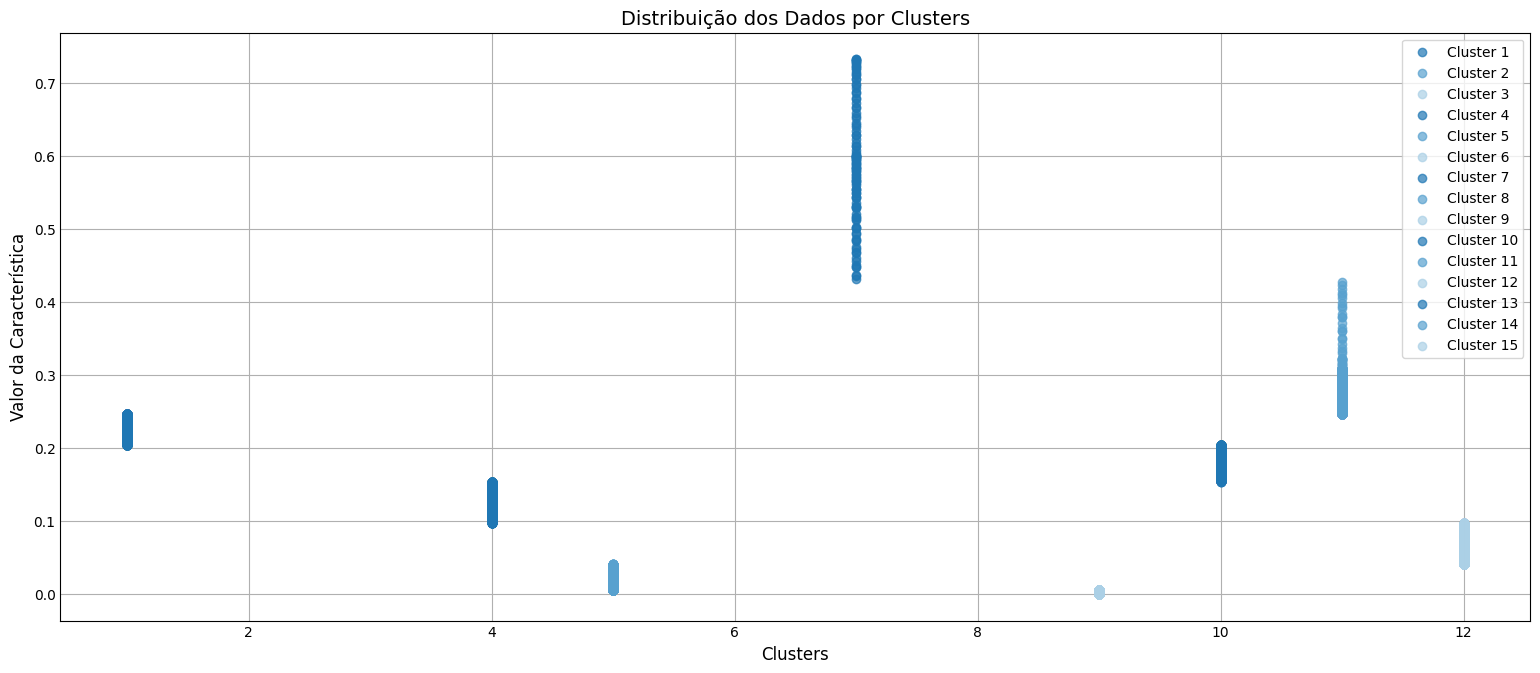

In [94]:
import matplotlib.pyplot as plt

# Gerando o gráfico de dispersão para cada cluster
plt.figure(figsize=(15, 6))

# A ideia é iterar sobre os clusters e plotar os pontos
for cluster in cluster_df.columns:
    # Pegando os índices dos dados que pertencem ao cluster
    cluster_data = cluster_df[cluster_df[cluster] > 0]  # Assumindo que os dados são binários, ou seja, 1 para pertencente ao cluster
    plt.scatter([cluster] * len(cluster_data), cluster_data[cluster], label=f'Cluster {cluster}', alpha=0.7)

# Adicionando título e rótulos aos eixos
plt.title("Distribuição dos Dados por Clusters", fontsize=14)
plt.xlabel("Clusters", fontsize=12)
plt.ylabel("Valor da Característica", fontsize=12)

# Adicionando legenda
plt.legend()

# Exibindo o gráfico
plt.show()


Tamanho de cluster_df: 84411
Tamanho de clusters: 84411


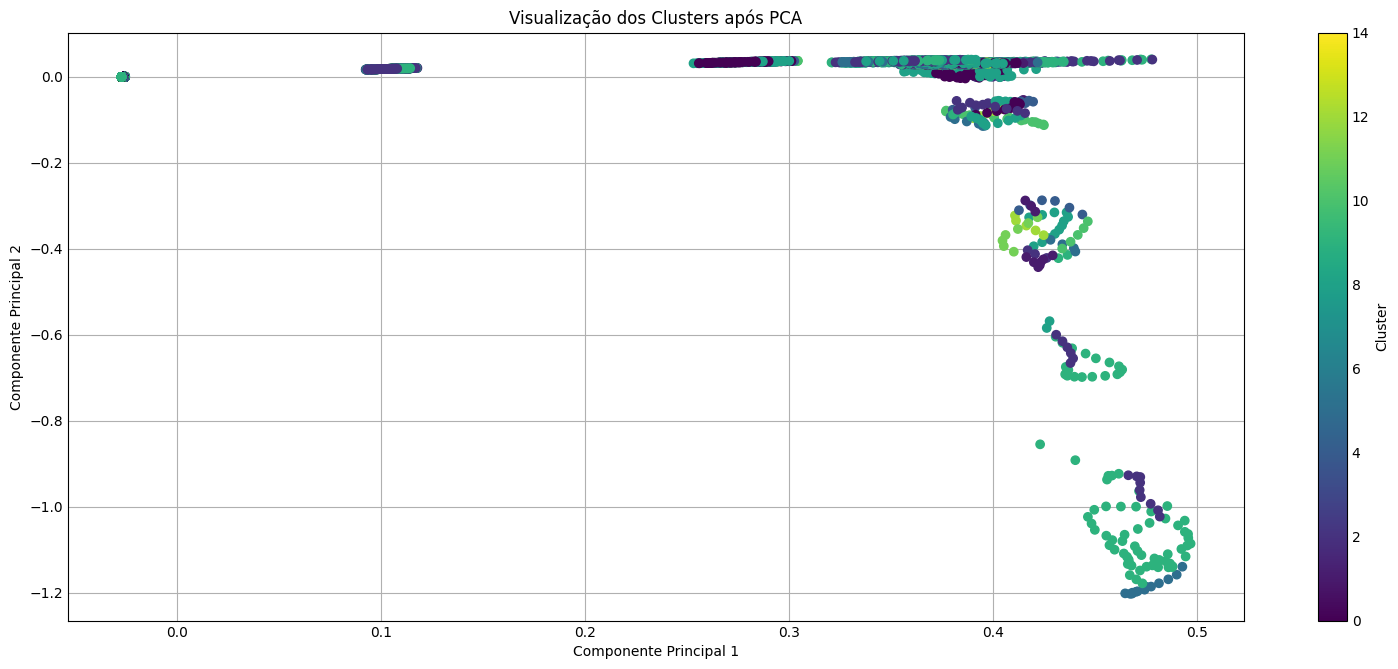

In [97]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Supondo que `cluster_df` tenha os dados que foram usados no PCA e que `clusters` seja o resultado do modelo KMeans.

# Verifique se o número de elementos em clusters corresponde ao número de linhas de cluster_df
print("Tamanho de cluster_df:", cluster_df.shape[0])  # Número de linhas em cluster_df
print("Tamanho de clusters:", len(clusters))  # Número de clusters gerados

# Se necessário, ajuste clusters para corresponder ao número de amostras
if len(clusters) != cluster_df.shape[0]:
    print("Ajustando o número de clusters.")
    # Aqui você deve atribuir `clusters` ao número correto de amostras
    clusters = clusters[:cluster_df.shape[0]]  # Ajuste o vetor clusters para corresponder às amostras

# Reduzindo a dimensionalidade com PCA para visualizar em 2D
pca = PCA(n_components=2)
ecg_clean_pca = pca.fit_transform(cluster_df)
plt.figure(figsize=(15, 6))
# Visualizando os clusters em 2D
plt.scatter(ecg_clean_pca[:, 0], ecg_clean_pca[:, 1], c=clusters, cmap='viridis')
plt.title("Visualização dos Clusters após PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Cluster")
plt.show()


Tamanho de ecg_clean_pca: (84411, 2)
Tamanho de clusters: 84411


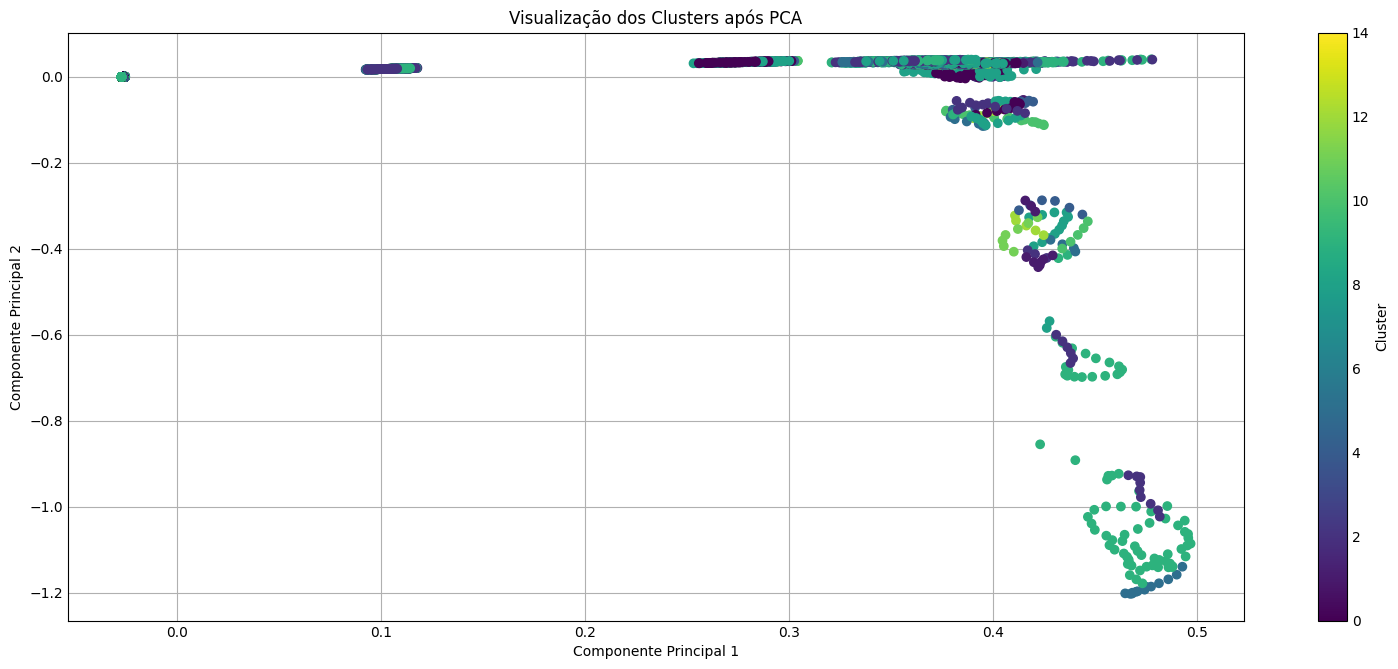

In [98]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Reduzindo a dimensionalidade com PCA para visualizar em 2D
pca = PCA(n_components=2)
ecg_clean_pca = pca.fit_transform(cluster_df)

# Verificando se clusters tem o mesmo número de elementos
print("Tamanho de ecg_clean_pca:", ecg_clean_pca.shape)
print("Tamanho de clusters:", len(clusters))

# Verifique se o número de elementos de clusters é igual ao número de linhas em ecg_clean_pca
if len(clusters) == ecg_clean_pca.shape[0]:
    # Visualizando os clusters em 2D
    plt.figure(figsize=(15, 6))
    plt.scatter(ecg_clean_pca[:, 0], ecg_clean_pca[:, 1], c=clusters, cmap='viridis')
    plt.title("Visualização dos Clusters após PCA")
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.colorbar(label="Cluster")
    plt.show()
else:
    print("Erro: O número de clusters não corresponde ao número de amostras.")


# Agora vou testar o quanto as clusters são precisa a separação que o neurokit

Métricas

Adjusted Rand Index (ARI)   <span style="color:red">testado essa métrica, não se aplica</span>


- Essa métrica mede a similaridade entre os clusters e os rótulos reais, ignorando o efeito do acaso. Ela varia de -1 a 1, onde 1 significa que os clusters correspondem perfeitamente aos rótulos.

Normalized Mutual Information (NMI)

- O NMI mede a dependência mútua entre os clusters e os rótulos reais. Ele varia de 0 a 1, onde 1 indica clusters idênticos aos rótulos reais.

Homogeneidade, Completude e V-measure

Essas três métricas ajudam a entender a qualidade dos clusters:

- Homogeneidade: Mede se cada cluster contém apenas um rótulo real.
- Completude: Mede se todos os pontos de um mesmo rótulo real estão no mesmo cluster.
- V-measure: Média harmônica entre homogeneidade e completude.

Silhouette Score (Se não houver rótulos reais)

- Se você não tem rótulos reais e quer avaliar a qualidade dos clusters com base apenas na separação dos dados, pode usar o Silhouette Score. Ele mede o quão bem os pontos estão agrupados dentro dos clusters.

In [168]:
# dados seprado do neurokit 


# Processar com Neurokit2
ecg_x, _ = nk.ecg_process(ecg_x, sampling_rate=1000, method='neurokit') 

# Processamento dos dados

import pandas as pd

# Lista de colunas que indicam eventos no ECG
colunas = ['ECG_R_Peaks', 'ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 
           'ECG_Q_Peaks', 'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 
           'ECG_T_Peaks', 'ECG_T_Onsets', 'ECG_T_Offsets', 'ECG_Phase_Atrial',
           'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular',
           'ECG_Phase_Completion_Ventricular']



In [169]:
import pandas as pd

def contar_1(df, colunas):
    """
    Função que conta a quantidade de valores 1 em cada coluna do DataFrame.

    Parâmetros:
    - df: DataFrame contendo os dados.
    - colunas: lista de colunas para contar os valores 1.

    Retorno:
    - Dicionário com o número de valores 1 para cada coluna.
    """
    contagem = {}

    for coluna in colunas:
        # Contar o número de 1 na coluna
        contagem[coluna] = (df[coluna] == 1).sum()

    return contagem


# Lista de colunas que indicam eventos no ECG
colunas = ['ECG_R_Peaks', 'ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 
           'ECG_Q_Peaks', 'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 
           'ECG_T_Peaks', 'ECG_T_Onsets', 'ECG_T_Offsets', 'ECG_Phase_Atrial',
           'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular',
           'ECG_Phase_Completion_Ventricular']


# Aplicando a função
contagem_resultado = contar_1(ecg_x, colunas)

# Verificar o resultado
contagem_resultado


{'ECG_R_Peaks': np.int64(290),
 'ECG_P_Peaks': np.int64(288),
 'ECG_P_Onsets': np.int64(288),
 'ECG_P_Offsets': np.int64(288),
 'ECG_Q_Peaks': np.int64(281),
 'ECG_R_Onsets': np.int64(262),
 'ECG_R_Offsets': np.int64(276),
 'ECG_S_Peaks': np.int64(289),
 'ECG_T_Peaks': np.int64(279),
 'ECG_T_Onsets': np.int64(279),
 'ECG_T_Offsets': np.int64(279),
 'ECG_Phase_Atrial': np.int64(58844),
 'ECG_Phase_Completion_Atrial': np.int64(575),
 'ECG_Phase_Ventricular': np.int64(92207),
 'ECG_Phase_Completion_Ventricular': np.int64(557)}

In [222]:
import pandas as pd
import numpy as np

def tipo_de_ondas_df(ecg, limite=300):
    tipos_ondas = {}

    for coluna in colunas:
        
        valores = ecg.loc[ecg[coluna] == 1, 'ECG_Clean'].values  
        

        # Ajustar o tamanho da coluna para ter exatamente 'limite' linhas
        if len(valores) < limite:
            valores = np.pad(valores, (0, limite - len(valores)), 'constant', constant_values=0) # ou constant_values=np.nan muito sensivel essa logica se for calular para media desvio padrão minimo maximo ou outras equações para analise estastistico está errado pois o zero dutera o resultado mais o motivo que estou colocando é para preencher os valores ausente para que todas as colunas venha ter a mesma dimensão. 
        else:
            valores = valores[:limite]  

        tipos_ondas[coluna] = valores  

    return pd.DataFrame(tipos_ondas)

# Aplicando a função
df_ecg = tipo_de_ondas_df(ecg_x)

In [ ]:
# df_tipos_ondas[df_tipos_ondas['ECG_Phase_Completion_Ventricular']==0] # importante 

# vou pegar somente 300 amostra da clusters 
cluster_df = cluster_df.iloc[0:300]



In [ ]:
cluster_df.columns = colunas # renomando as colunas pra ficar iguais

In [231]:
cluster_df.head()

,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,0.211651,-0.009393,-0.637048,0.098497,0.005022,-0.108443,0.436924,-0.023413,0.001755,0.164249,0.248003,0.045402,-0.218472,-0.412227,0
1,0.219289,-0.009680,-0.653228,0.109604,0.005322,-0.125770,0.456305,-0.025813,0.002112,0.174637,0.249797,0.055534,-0.238223,-0.429678,0
2,0.226201,-0.009892,-0.668578,0.120736,0.005548,-0.143459,0.475581,-0.028031,0.002469,0.184650,0.250853,0.065978,-0.258169,-0.446574,0
3,0.232352,-0.010016,-0.683022,0.131761,0.005680,-0.161517,0.494644,-0.030037,0.002813,0.194232,0.251191,0.076665,-0.278214,-0.462920,0
4,0.237621,-0.010066,-0.696472,0.142717,0.005742,-0.180050,0.513389,-0.031730,0.003151,0.203282,0.250879,0.087516,-0.298203,-0.478721,0


In [ ]:
# Função para calcular estatísticas ignorando os valores zero
def calcular_estatisticas_sem_zero(ondas):
    # Filtrar os valores diferentes de zero
    ondas_filtradas = ondas[ondas != 0]
    
    # Calcular as estatísticas apenas com os valores diferentes de zero
    estatisticas = {
        "mean": ondas_filtradas.mean(),
        "std": ondas_filtradas.std(),
        "max": ondas_filtradas.max(),
        "min": ondas_filtradas.min(),
        "25%": ondas_filtradas.quantile(0.25),
        "50%": ondas_filtradas.quantile(0.50),
        "75%": ondas_filtradas.quantile(0.75)
    }
    
    return estatisticas



In [223]:
# usando pra valores do ecg pela neurokit 
estatisticas_final = {}

for coluna in df_ecg.columns:
    estatisticas_final[coluna] = calcular_estatisticas_sem_zero(df_ecg[coluna])
    
df_ecg_est = pd.DataFrame.from_dict(estatisticas_final, orient='columns')

In [224]:
df_ecg_est

,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
mean,0.227312,0.001796,-0.018224,-0.020221,-0.029015,-0.005218,-0.019667,-0.047413,-0.005061,-0.032662,-0.031808,0.014404,0.109743,0.031643,0.092079
std,0.074456,0.040734,0.012334,0.032535,0.037507,0.018693,0.022648,0.061222,0.043643,0.036672,0.016177,0.058822,0.122929,0.100237,0.136711
max,0.300668,0.558720,0.027414,0.008085,0.004537,0.214486,0.266966,0.008593,0.281703,0.106915,0.015795,0.242547,0.284033,0.242744,0.288262
min,-0.094913,-0.035726,-0.056044,-0.539598,-0.563090,-0.037014,-0.067519,-0.791916,-0.044120,-0.563652,-0.070565,-0.015443,-0.030191,-0.043796,-0.070144
25%,0.232237,-0.009773,-0.025305,-0.025366,-0.032883,-0.014286,-0.029130,-0.049956,-0.020768,-0.041615,-0.042455,-0.009756,-0.000471,-0.039903,-0.031933
50%,0.250695,-0.000974,-0.018496,-0.017920,-0.025303,-0.006187,-0.020631,-0.041922,-0.014726,-0.033235,-0.033552,-0.004761,0.013988,-0.024547,-0.002083
75%,0.262111,0.005749,-0.009840,-0.010125,-0.019187,0.001466,-0.014427,-0.034743,-0.000949,-0.024562,-0.022109,0.000922,0.245898,0.126364,0.245898


In [232]:
# usando pela clusters 
estatisticas_final = {}

for coluna in cluster_df.columns:
    estatisticas_final[coluna] = calcular_estatisticas_sem_zero(cluster_df[coluna])
    
df_cluster_est = pd.DataFrame.from_dict(estatisticas_final, orient='columns')

In [233]:
df_cluster_est

,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
mean,0.226921,-0.016632,-0.738856,0.126528,0.011940,-0.141857,0.592169,-0.027752,-0.002257,0.179639,0.259464,0.067009,-0.288643,-0.516283,NaN
std,0.012542,0.003706,0.052477,0.016290,0.007326,0.032557,0.084864,0.003934,0.004036,0.014368,0.008986,0.016939,0.047712,0.060394,NaN
max,0.246543,-0.009137,-0.631813,0.153578,0.040258,-0.094713,0.732603,-0.021888,0.004920,0.203677,0.281134,0.096910,-0.217199,-0.404446,NaN
min,0.204065,-0.021841,-0.816197,0.097394,0.004972,-0.216008,0.431657,-0.036629,-0.009018,0.153997,0.246654,0.040362,-0.401098,-0.627188,NaN
25%,0.216342,-0.019817,-0.775670,0.111812,0.006411,-0.161681,0.530661,-0.030164,-0.006240,0.167353,0.251396,0.052278,-0.309703,-0.569043,NaN
50%,0.227413,-0.017491,-0.747502,0.127349,0.009519,-0.134557,0.588846,-0.027040,-0.002499,0.181101,0.258502,0.066298,-0.284084,-0.520286,NaN
75%,0.238435,-0.014052,-0.699484,0.140186,0.016379,-0.116815,0.658702,-0.024761,0.000677,0.191780,0.266537,0.081213,-0.250025,-0.465582,NaN


In [234]:
# Calculando a diferença entre os dois DataFrames
df_diff = df_ecg_est - df_cluster_est

In [235]:
df_diff

,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
mean,0.000391,0.018428,0.720632,-0.146750,-0.040955,0.136639,-0.611835,-0.019662,-0.002805,-0.212301,-0.291272,-0.052605,0.398387,0.547926,NaN
std,0.061914,0.037027,-0.040143,0.016245,0.030180,-0.013863,-0.062216,0.057289,0.039607,0.022304,0.007192,0.041883,0.075217,0.039843,NaN
max,0.054125,0.567857,0.659227,-0.145493,-0.035721,0.309199,-0.465638,0.030481,0.276783,-0.096762,-0.265339,0.145637,0.501233,0.647190,NaN
min,-0.298978,-0.013884,0.760153,-0.636992,-0.568061,0.178994,-0.499176,-0.755288,-0.035101,-0.717648,-0.317219,-0.055805,0.370907,0.583393,NaN
25%,0.015895,0.010044,0.750365,-0.137178,-0.039294,0.147395,-0.559791,-0.019792,-0.014527,-0.208968,-0.293850,-0.062035,0.309231,0.529140,NaN
50%,0.023283,0.016518,0.729005,-0.145270,-0.034821,0.128370,-0.609477,-0.014882,-0.012227,-0.214336,-0.292054,-0.071059,0.298071,0.495739,NaN
75%,0.023676,0.019801,0.689645,-0.150312,-0.035566,0.118280,-0.673128,-0.009982,-0.001627,-0.216342,-0.288646,-0.080292,0.495923,0.591946,NaN


## Agora vou testar usando o X

dos pacientes 

## Cálculos para diferentes durações de sinal ECG

### 1. Para 5 minutos de sinal:
1. **Número de segundos em 5 minutos**:  
   5 minutos = 5 * 60 = 300 segundos.

2. **Número de amostras em 5 minutos**:  
   Como há 1.000 amostras por segundo, em 300 segundos teremos:
   \[
   \text{Amostras} = 1.000 \times 300 = 300.000 \, \text{amostras}.
   \]

Portanto, **5 minutos de sinal** corresponderiam a **300.000 amostras**.

---


## Irei testar Redes neurais com as clusters ecomapara o resultado da classificação de ondas do Neurokit 

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


def tratamento_dados(dados, filtro):
    """
    Função para tratar os dados, filtrando colunas específicas e realizando pré-processamento.

    Parâmetros:
    - dados (DataFrame): O dataset a ser tratado.
    - filtro (str): Palavra-chave para selecionar as colunas (default: "ECG_R_Peaks").

    Retorna:
    - X_train_scaled, X_test_scaled, y_train, y_test
    """

    # Filtrar colunas que contêm a palavra-chave no nome
    colunas_filtradas = dados.filter(like=filtro).columns
    X = dados[colunas_filtradas].values  # Apenas colunas filtradas

    # Garantir que o target seja separado corretamente
    y = dados['target'].values  

    # Transformar os rótulos usando LabelEncoder
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Verificar o mapeamento dos rótulos
    print("Rótulos originais:", np.unique(y))
    print("Rótulos transformados:", np.unique(y_encoded))

    # Dividir em treino e teste (80% treino, 20% teste)
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

    # Normalizar os dados
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Converter o target para one-hot encoding se for multiclasse
    num_classes = len(np.unique(y_encoded))
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

